In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import re
import matplotlib.dates as mdates

# Figure S19

In [2]:
year_df = pd.read_csv('../data/openalex_summary_by_year_240419.csv')
sources = pd.read_csv('../data/sources_scopus_wos_indexing_240418.csv')
year_df = year_df[year_df['year'] <= 2020]

In [3]:
def lingress_log2(x, y, project):
    '''
        x is years (e.g. 2011- 2020) 
        y is undisturbed count (not log-transformed)
        project is years to project over
        returns non-log-transformed projection over project years
        AND top and bottom bounds of 95% confidence
        project_from is 2021 value (first year of projection)
    '''
    res = scipy.stats.linregress(x, np.log2(y))
    slope = res.slope
    print(1/slope)
    intercept = res.intercept
    slope_err = res.stderr
    int_err = res.intercept_stderr
    untransformed_project = (slope*project+intercept)
    # 1.96 is 95%
    # 3.291 99.9%
    ci_97_5 = untransformed_project[0] + (project_x - project_x[0])*(slope + 3.291*slope_err)
    ci_2_5 = untransformed_project[0] + (project_x - project_x[0])*(slope - 3.291*slope_err)
    
    return 2**untransformed_project, 2**ci_2_5, 2**ci_97_5, slope

In [4]:
project_x = np.arange(2020, 2036)
x, y = year_df[(year_df['year'] <= 2020)]['year'].tail(10).values, 
year_df[(year_df['year'] <= 2020)]['n_journals'].tail(10).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)

11.965021035880289


19.318007857773402
1.5962881243946585
4.025836001029971
4.650628698442158
21.729750948530725
1.6586021741159602
4.025836001029971
3.1368426574157793
15.005821132241799
1.5344016863842709
3.623157647400268
3.297633980774512
72.1363415908808
2.032142685116108
679.3086266804575
2.0690096609177635
12.07368622947756
2.2074170443240284


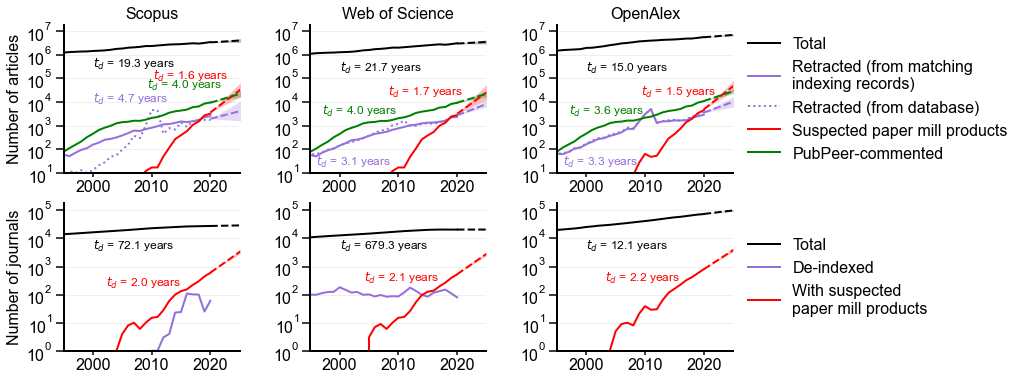

In [5]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6), gridspec_kw={'wspace':0.4})

project_x = np.arange(2020, 2036)

# Total, retractions, and paper mill products

# Scopus
ax = axes[0][0]
ax.plot(year_df['year'], year_df['n_scopus'], color='k', linewidth=2)
ax.plot(year_df['year'], year_df['n_scopus_retracted'], color='mediumpurple', linewidth=2)
ax.plot(year_df['year'], year_df['n_scopus_database_retractions'], color='mediumpurple', 
        linewidth=2, linestyle='dotted')
ax.plot(year_df['year'], year_df['n_paper_mill_scopus'], color='r', linewidth=2)
ax.plot(year_df['year'], year_df['n_pubpeer_scopus'], color='g', linewidth=2, label='PubPeer-commented')
ax.set_title('Scopus', fontsize=16)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=300_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill_scopus'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2023, y=90_000, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_pubpeer_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2022, y=40_000, ha='right', c='g', fontsize=12)
ax.plot(project_x, project_y, color='g', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus_database_retractions'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=10_000, ha='left', c='mediumpurple', fontsize=12)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)

# Wos
ax = axes[0][1]
ax.plot(year_df['year'], year_df['n_wos'], color='k', linewidth=2)
ax.plot(year_df['year'], year_df['n_wos_retracted'], color='mediumpurple', linewidth=2)
ax.plot(year_df['year'], year_df['n_wos_database_retractions'], color='mediumpurple', 
        linewidth=2, linestyle='dotted')
ax.plot(year_df['year'], year_df['n_paper_mill_wos'], color='r', linewidth=2)
ax.plot(year_df['year'], year_df['n_pubpeer_wos'], color='g', linewidth=2, label='PubPeer-commented')
ax.set_title('Web of Science', fontsize=16)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=200_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2021, y=20_000, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_pubpeer_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=1997, y=3_000, ha='left', c='g', fontsize=12)
ax.plot(project_x, project_y, color='g', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos_database_retractions'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=1996, y=20, ha='left', c='mediumpurple', fontsize=12)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)

# OpenAlex
ax = axes[0][2]
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=2, label='Total')
ax.plot(year_df['year'], year_df['n_retracted'], color='mediumpurple', linewidth=2, label='Retracted (from matching\nindexing records)')
ax.plot(year_df['year'], year_df['n_openalex_database_retractions'], color='mediumpurple', 
        linewidth=2, linestyle='dotted', label='Retracted (from database)')
ax.plot(year_df['year'], year_df['n_paper_mill'], color='r', linewidth=2, label='Suspected paper mill products')
ax.plot(year_df['year'], year_df['n_pubpeer'], color='g', linewidth=2, label='PubPeer-commented')
ax.set_title('OpenAlex', fontsize=16)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['total_works'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=200_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2022, y=20_000, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_pubpeer'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=1997, y=3_000, ha='left', c='g', fontsize=12)
ax.plot(project_x, project_y, color='g', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_openalex_database_retractions'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=1996, y=20, ha='left', c='mediumpurple', fontsize=12)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)

# Journals total, journals paper mill, journals de-indexed

# scopus
ax = axes[1][0]

count_array = sources[sources['scopus_last_year'] != -1].drop_duplicates('source_id').groupby('scopus_last_year').count()['source_id']
count_array = count_array.loc[count_array.index <= 2020].copy()

ax.plot(year_df['year'], year_df['n_scopus_journals'], color='k', linewidth=2)
ax.plot(count_array.index, count_array, color='mediumpurple', 
        linewidth=2, linestyle='solid')
ax.plot(year_df['year'], year_df['n_scopus_paper_mill_journals'], color='r', linewidth=2)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=4_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus_paper_mill_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2015, y=200, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

# wos
ax = axes[1][1]

count_array = sources[sources['wos_last_year'] != -1].drop_duplicates('source_id').groupby('wos_last_year').count()['source_id']
count_array = count_array.loc[count_array.index <= 2020].copy()

ax.plot(year_df['year'], year_df['n_wos_journals'], color='k', linewidth=2)
ax.plot(count_array.index, count_array, color='mediumpurple', 
        linewidth=2, linestyle='solid')
ax.plot(year_df['year'], year_df['n_wos_paper_mill_journals'], color='r', linewidth=2)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=4_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos_paper_mill_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2017, y=300, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

# openalex
ax = axes[1][2]

ax.plot(year_df['year'], year_df['n_journals'], color='k', linewidth=2, label='Total')
ax.plot([], [], color='mediumpurple', 
        linewidth=2, linestyle='solid', label='De-indexed')
ax.plot(year_df['year'], year_df['n_paper_mill_journals'], color='r', linewidth=2, label='With suspected\npaper mill products')

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=4_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2016, y=300, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)


for ax in axes[0,:]:
    ax.set_xlim([1995, 2025])
    ax.set_yscale('log')
    #ax.set_ylim([0,195])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=16, axis='both', width=1.5)
    ax.set_xticks([2000, 2010, 2020])
    multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
    ax.yaxis.set_ticks(multi)
    ax.set_ylim([10,1.9*10e6])

    ax.tick_params(axis='y', length=8, which='major')
    ax.tick_params(axis='y', length=4, which='minor')
    ax.grid(axis='y', alpha=0.25)

axes[0][0].set_ylabel('Number of articles', fontsize=16)
axes[1][0].set_ylabel('Number of journals', fontsize=16)
axes[0][2].legend(fontsize=16, frameon=False, bbox_to_anchor=(1,0.5), loc='center left')
axes[1][2].legend(fontsize=16, frameon=False, bbox_to_anchor=(1,0.5), loc='center left')

for ax in axes[1,:]:
    ax.set_xlim([1995, 2025])
    ax.set_yscale('log')
    #ax.set_ylim([0,195])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=16, axis='both', width=1.5)
    ax.set_xticks([2000, 2010, 2020])
    multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
    ax.yaxis.set_ticks(multi)
    ax.set_ylim([1,1.9*10e4])

    ax.tick_params(axis='y', length=8, which='major')
    ax.tick_params(axis='y', length=4, which='minor')
    ax.grid(axis='y', alpha=0.25)
    
#plt.savefig('../img/240419_openalex_summary.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/240419_openalex_summary.pdf', bbox_inches='tight')

# Figure S20

19.318007857773402
1.5962881243946585
3.987817003372319
4.650628698442158
21.729750948530725
1.6586021741159602
4.025836001029971
3.1368426574157793
15.005821132241799
1.5344016863842709
3.987817003372319
3.297633980774512
72.1363415908808
2.032142685116108
679.3086266804575
2.0690096609177635
12.07368622947756
2.2074170443240284


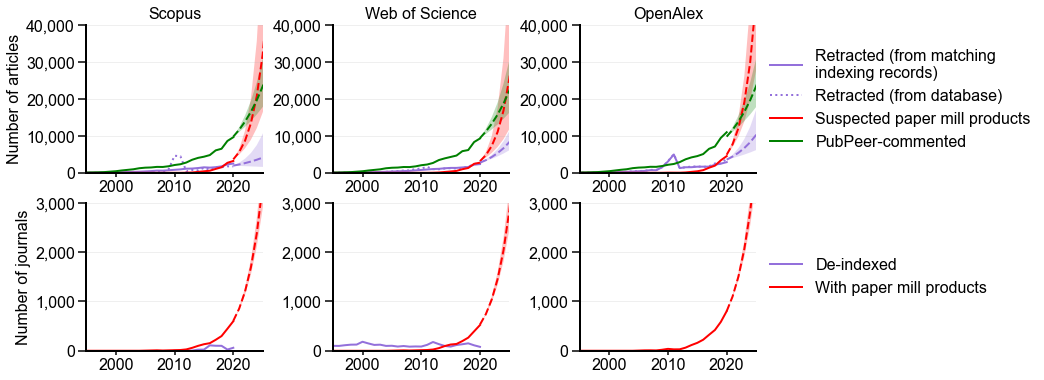

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6), gridspec_kw={'wspace':0.4})

project_x = np.arange(2020, 2036)

# Total, retractions, and paper mill products

# Scopus
ax = axes[0][0]
ax.plot(year_df['year'], year_df['n_scopus'], color='k', linewidth=2)
ax.plot(year_df['year'], year_df['n_scopus_retracted'], color='mediumpurple', linewidth=2)
ax.plot(year_df['year'], year_df['n_scopus_database_retractions'], color='mediumpurple', 
        linewidth=2, linestyle='dotted')
ax.plot(year_df['year'], year_df['n_paper_mill_scopus'], color='r', linewidth=2)
ax.plot(year_df['year'], year_df['n_pubpeer_scopus'], color='g', linewidth=2, label='PubPeer-commented')
ax.set_title('Scopus', fontsize=16)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=200_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill_scopus'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2023, y=30_000, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_pubpeer_scopus'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2022, y=40_000, ha='right', c='g', fontsize=12)
ax.plot(project_x, project_y, color='g', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus_database_retractions'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=1996, y=8_000, ha='left', c='mediumpurple', fontsize=12)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)

# Wos
ax = axes[0][1]
ax.plot(year_df['year'], year_df['n_wos'], color='k', linewidth=2)
ax.plot(year_df['year'], year_df['n_wos_retracted'], color='mediumpurple', linewidth=2)
ax.plot(year_df['year'], year_df['n_wos_database_retractions'], color='mediumpurple', 
        linewidth=2, linestyle='dotted')
ax.plot(year_df['year'], year_df['n_paper_mill_wos'], color='r', linewidth=2)
ax.plot(year_df['year'], year_df['n_pubpeer_wos'], color='g', linewidth=2, label='PubPeer-commented')
ax.set_title('Web of Science', fontsize=16)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=200_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2021, y=20_000, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_pubpeer_wos'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2022, y=40_000, ha='right', c='g', fontsize=12)
ax.plot(project_x, project_y, color='g', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos_database_retractions'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2020, y=3_000, ha='right', c='mediumpurple', fontsize=12)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)

# OpenAlex
ax = axes[0][2]
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=2)
ax.plot(year_df['year'], year_df['n_retracted'], color='mediumpurple', linewidth=2, label='Retracted (from matching\nindexing records)')
ax.plot(year_df['year'], year_df['n_openalex_database_retractions'], color='mediumpurple', 
        linewidth=2, linestyle='dotted', label='Retracted (from database)')
ax.plot(year_df['year'], year_df['n_paper_mill'], color='r', linewidth=2, label='Suspected paper mill products')
ax.plot(year_df['year'], year_df['n_pubpeer'], color='g', linewidth=2, label='PubPeer-commented')
ax.set_title('OpenAlex', fontsize=16)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['total_works'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=200_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2022, y=20_000, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_pubpeer_scopus'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2022, y=40_000, ha='right', c='g', fontsize=12)
ax.plot(project_x, project_y, color='g', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_openalex_database_retractions'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2020, y=4_000, ha='right', c='mediumpurple', fontsize=12)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)

# Journals total, journals paper mill, journals de-indexed

# scopus
ax = axes[1][0]

count_array = sources[sources['scopus_last_year'] != -1].drop_duplicates('source_id').groupby('scopus_last_year').count()['source_id']
count_array = count_array.loc[count_array.index <= 2020].copy()

ax.plot(year_df['year'], year_df['n_scopus_journals'], color='k', linewidth=2)
ax.plot(count_array.index, count_array, color='mediumpurple', 
        linewidth=2, linestyle='solid')
ax.plot(year_df['year'], year_df['n_scopus_paper_mill_journals'], color='r', linewidth=2)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=4_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_scopus_paper_mill_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2015, y=200, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

# wos
ax = axes[1][1]

count_array = sources[sources['wos_last_year'] != -1].drop_duplicates('source_id').groupby('wos_last_year').count()['source_id']
count_array = count_array.loc[count_array.index <= 2020].copy()

ax.plot(year_df['year'], year_df['n_wos_journals'], color='k', linewidth=2)
ax.plot(count_array.index, count_array, color='mediumpurple', 
        linewidth=2, linestyle='solid')
ax.plot(year_df['year'], year_df['n_wos_paper_mill_journals'], color='r', linewidth=2)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=4_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_wos_paper_mill_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2017, y=300, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)

# openalex
ax = axes[1][2]

ax.plot(year_df['year'], year_df['n_journals'], color='k', linewidth=2)
ax.plot([], [], color='mediumpurple', 
        linewidth=2, linestyle='solid', label='De-indexed')
ax.plot(year_df['year'], year_df['n_paper_mill_journals'], color='r', linewidth=2, label='With paper mill products')

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2000, y=4_000, fontsize=12)
ax.plot(project_x, project_y, color='k', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)

x, y = year_df[(year_df['year'] <= 2021)]['year'].tail(5).values, \
    year_df[(year_df['year'] <= 2021)]['n_paper_mill_journals'].tail(5).values
project_y, ci_2_5, ci_97_5, slope = lingress_log2(x,y,project_x)
#ax.text(s=r'$t_d$ = ' +'{:.1f} years'.format(1/slope), x=2016, y=300, ha='right', c='r', fontsize=12)
ax.plot(project_x, project_y, color='r', linewidth=2, linestyle='dashed')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='r', alpha=0.25, linewidth=0)


for ax in axes[0,:]:
    ax.set_xlim([1995, 2025])
    #ax.set_yscale('log')
    #ax.set_ylim([0,195])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=16, axis='both', width=1.5)
    ax.set_xticks([2000, 2010, 2020])
    #multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
    #ax.yaxis.set_ticks(multi)
    ax.set_ylim([0,40_000])

    ax.tick_params(axis='y', length=8, which='major')
    ax.tick_params(axis='y', length=4, which='minor')
    ax.grid(axis='y', alpha=0.25)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axes[0][0].set_ylabel('Number of articles', fontsize=16)
axes[1][0].set_ylabel('Number of journals', fontsize=16)
axes[0][2].legend(fontsize=16, frameon=False, bbox_to_anchor=(1,0.5), loc='center left')
axes[1][2].legend(fontsize=16, frameon=False, bbox_to_anchor=(1,0.5), loc='center left')

for ax in axes[1,:]:
    ax.set_xlim([1995, 2025])
    #ax.set_yscale('log')
    #ax.set_ylim([0,195])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=16, axis='both', width=1.5)
    ax.set_xticks([2000, 2010, 2020])
    #multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
    #ax.yaxis.set_ticks(multi)
    ax.set_ylim([0, 3_000])

    ax.tick_params(axis='y', length=8, which='major')
    ax.tick_params(axis='y', length=4, which='minor')
    ax.grid(axis='y', alpha=0.25)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
#plt.savefig('../img/240419_openalex_summary_linear.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/240419_openalex_summary_linear.pdf', bbox_inches='tight')

# Figure S22

In [7]:
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
rw_db = rw_db[(rw_db['RetractionNature'] == 'Retraction')]

rw_db['pub_year'] = [x.year for x in pd.to_datetime(rw_db['OriginalPaperDate'])]

In [8]:
rw_series = rw_db['pub_year'].value_counts().reindex(np.arange(1900, 2024)).fillna(0.0)

In [9]:
year_df = pd.read_csv('../data/openalex_summary_by_year_240419.csv')
sources = pd.read_csv('../data/sources_scopus_wos_indexing_240418.csv')
# year_df = year_df[year_df['year'] <= 2020]

Text(0.5, 0, 'Year of publication')

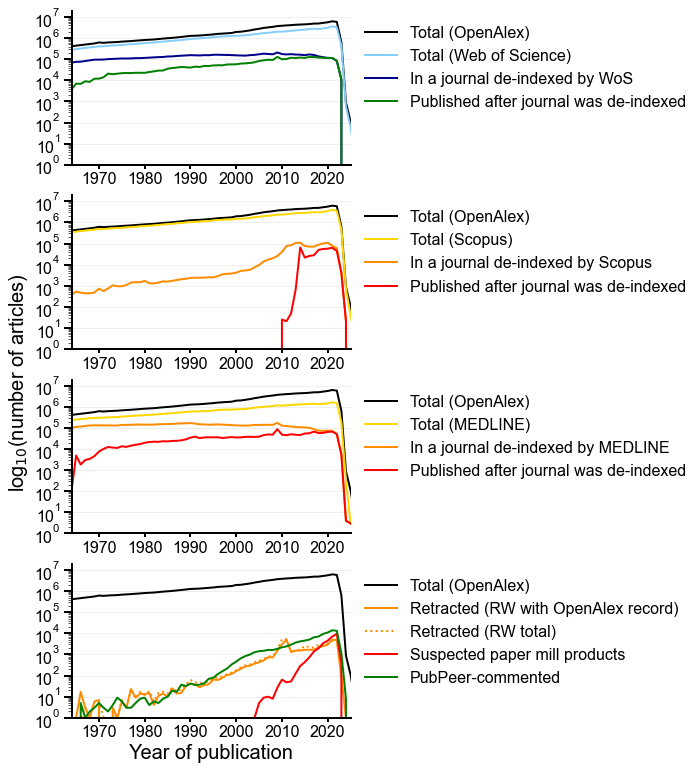

In [10]:
linewidth=2

fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(5,13))

ax = axes[0]
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=linewidth, label='Total (OpenAlex)')
ax.plot(year_df['year'], year_df['n_wos'], color='lightskyblue', linewidth=linewidth, label='Total (Web of Science)')
ax.plot(year_df['year'], year_df['n_wos_deindex'], color='darkblue', linewidth=linewidth, label='In a journal de-indexed by WoS')
ax.plot(year_df['year'], year_df['n_wos_after_deindex'], color='green', linewidth=linewidth, label='Published after journal was de-indexed')
ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

ax = axes[1]
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=linewidth, label='Total (OpenAlex)')
ax.plot(year_df['year'], year_df['n_scopus'], color='gold', linewidth=linewidth, label='Total (Scopus)')
ax.plot(year_df['year'], year_df['n_scopus_deindex'], color='darkorange', linewidth=linewidth, label='In a journal de-indexed by Scopus')
ax.plot(year_df['year'], year_df['n_scopus_after_deindex'], color='red', linewidth=linewidth, label='Published after journal was de-indexed')
ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

ax = axes[2]
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=linewidth, label='Total (OpenAlex)')
ax.plot(year_df['year'], year_df['n_pubmed'], color='gold', linewidth=linewidth, label='Total (MEDLINE)')
ax.plot(year_df['year'], year_df['n_pubmed_deindex'], color='darkorange', linewidth=linewidth, label='In a journal de-indexed by MEDLINE')
ax.plot(year_df['year'], year_df['n_pubmed_after_deindex'], color='red', linewidth=linewidth, label='Published after journal was de-indexed')
ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

ax = axes[3]
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=linewidth, label='Total (OpenAlex)')
ax.plot(year_df['year'], year_df['n_retracted'], color='darkorange', linewidth=linewidth, label='Retracted (RW with OpenAlex record)')
ax.plot(rw_series, color='darkorange', linewidth=linewidth, linestyle='dotted', label='Retracted (RW total)')
ax.plot(year_df['year'], year_df['n_paper_mill'], color='red', linewidth=linewidth, label='Suspected paper mill products')
ax.plot(year_df['year'], year_df['n_pubpeer'], color='g', linewidth=linewidth, label='PubPeer-commented')
ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

for ax in axes:
    ax.set_xlim([1964, 2025])
    ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=16, axis='both', width=linewidth)
    
    multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
    #ax.yaxis.set_ticks([1,1000,10e4,10e6])
    ax.yaxis.set_ticks(multi)
    a_tick_array = []
    for mult in multi:
        a_tick_array = a_tick_array + list(mult*np.array([1,2,3,4,5,6,7,8,9]))
        ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(a_tick_array))
        
    ax.tick_params(axis='y', length=8, which='major')
    ax.tick_params(axis='y', length=4, which='minor')
    ax.grid(axis='y', alpha=0.25)
    ax.set_ylim([1,1.9*10e6])
    ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])
    
axes[1].set_ylabel(r'log$_{10}$(number of articles)', ha='right', fontsize=20)
axes[3].set_xlabel('Year of publication', fontsize=20)

#plt.savefig('../img/240419_openalex_summary_all.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/240419_openalex_summary_all.pdf', bbox_inches='tight')

# Figure S21

In [11]:
def lingress(x, y, project):
    '''
        x is years (2016- 2020) 
        y is undisturbed count (not log-transformed)
        project is years to project over
        returns non-log-transformed projection over project years
        AND top and bottom bounds of 95% confidence
    '''
    res = scipy.stats.linregress(x, np.log10(y))
    slope = res.slope
    intercept = res.intercept
    slope_err = res.stderr
    untransformed_project = (slope*project+intercept)
    ci_97_5 = untransformed_project[0] + (project_x - project_x[0])*(slope + 1.96*slope_err)
    ci_2_5 = untransformed_project[0] + (project_x - project_x[0])*(slope - 1.96*slope_err)
    
    return 10**untransformed_project, 10**ci_2_5, 10**ci_97_5

def lingress_log2(x, y, project):
    '''
        x is years (2016- 2020) 
        y is undisturbed count (not log-transformed)
        project is years to project over
        returns non-log-transformed projection over project years
        AND top and bottom bounds of 95% confidence
    '''
    res = scipy.stats.linregress(x, np.log2(y))
    slope = res.slope
    print(slope)
    intercept = res.intercept
    slope_err = res.stderr
    untransformed_project = (slope*project+intercept)
    ci_97_5 = untransformed_project[0] + (project_x - project_x[0])*(slope + 1.96*slope_err)
    ci_2_5 = untransformed_project[0] + (project_x - project_x[0])*(slope - 1.96*slope_err)
    
    return 10**untransformed_project, 10**ci_2_5, 10**ci_97_5

meta NOT subset; don't know how to subset; dropped


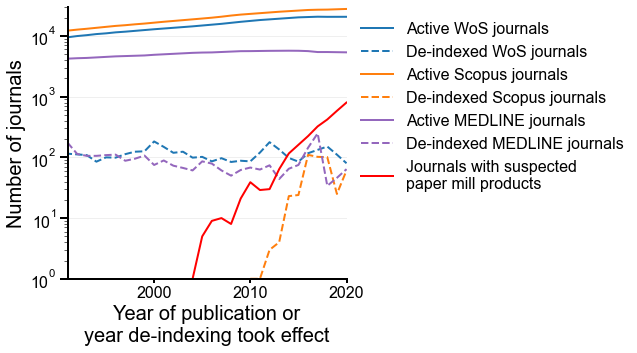

In [12]:
linewidth=2

fig = plt.figure(figsize=(5,5))
ax = plt.gca()

count_array = sources[sources['wos_last_year'] != -1].drop_duplicates('source_id').groupby('wos_last_year').count()['source_id']
count_array = count_array.loc[count_array.index < 2021]
ax.plot(year_df['year'], year_df['n_wos_journals'].values, 
        linewidth=linewidth, color=sns.color_palette()[0],
        label='Active WoS journals')
ax.plot(count_array, linewidth=linewidth, linestyle='dashed',
        label='De-indexed WoS journals', color=sns.color_palette()[0])

count_array = sources[sources['scopus_last_year'] != -1].drop_duplicates('source_id').groupby('scopus_last_year').count()['source_id']
count_array = count_array.loc[count_array.index < 2021].copy()
ax.plot(year_df['year'], year_df['n_scopus_journals'].values, 
        linewidth=linewidth, color=sns.color_palette()[1],
        label='Active Scopus journals')
ax.plot(count_array, linewidth=linewidth, linestyle='dashed',
        label='De-indexed Scopus journals', color=sns.color_palette()[1])

count_array = sources[sources['pubmed_last_year'] != -1].drop_duplicates('source_id').groupby('pubmed_last_year').count()['source_id']
count_array = count_array.loc[count_array.index < 2021].copy()
ax.plot(year_df['year'], year_df['n_pubmed_journals'].values, 
        linewidth=linewidth, color=sns.color_palette()[4],
        label='Active MEDLINE journals')
ax.plot(count_array, linewidth=linewidth, linestyle='dashed',
        label='De-indexed MEDLINE journals', color=sns.color_palette()[4])

ax.set_xlim([1991, 2020])
#ax.set_ylim([0,195])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]
ax.tick_params(labelsize=16, axis='both', width=linewidth)
ax.set_xticks([2000, 2010, 2020])
ax.set_yscale('log')

#ax.axvline(x=1964, linewidth=linewidth, color='k', linestyle='dashed', alpha=0.5, zorder=-1)
#ax.text(s='Web of Science founded', fontsize=14, rotation=90, ha='left', va='top', x=1965, y=170, alpha=0.5)

#ax.axvline(x=2004, linewidth=linewidth, color='k', linestyle='dashed', alpha=0.5, zorder=-1)
#ax.text(s='Scopus founded', fontsize=14, rotation=90, ha='left', va='bottom', x=2005, y=5, alpha=0.5)

ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False, loc='upper left')
ax.set_xlabel('Year of publication or\nyear de-indexing took effect', fontsize=20)
ax.set_ylabel('Number of journals', fontsize=20)
ax.set_ylim([1,3*10e3])

ax.tick_params(axis='y', length=8, which='major')
ax.tick_params(axis='y', length=4, which='minor')
ax.grid(axis='y', alpha=0.25)

plt.savefig('../img/de_indexing_events_summary_230503.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/de_indexing_events_summary_230503.pdf', bbox_inches='tight')

ax.plot(year_df['year'], year_df['n_paper_mill_journals'].values, 
        linewidth=linewidth, color='red',
        label='Journals with suspected\npaper mill products')

ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False, loc='upper left')
#plt.savefig('../img/240419_de_indexing_events_summary.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/240419_de_indexing_events_summary.pdf', bbox_inches='tight')

# Figure 5

In [13]:
year_df = pd.read_csv('../data/openalex_summary_by_year_240419.csv')

year_df = year_df[year_df['year'] <= 2020]

In [14]:
year_df_by_retraction = pd.read_csv('../data/240421_retractions_by_year_by_batch_size.csv', index_col=0)

Text(-0.03, 0.34, 'c')

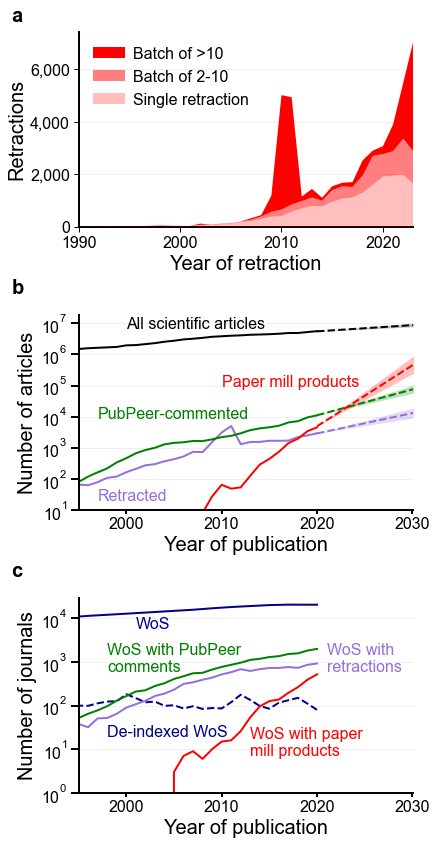

In [18]:
linewidth=2

project_x = np.arange(2020, 2036)

threshs = [str(x) for x in [1,2,11,10_000]]

fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(6,14), gridspec_kw={'hspace':0.45, 'wspace':0.25})

labels = ['Single retraction', 
          'Batch of 2-10', 
          'Batch of >10']

# panel a
ax = axes[0]
for index, alpha, label in zip(range(len(threshs)-1), [0.25,0.5,1.0], labels):
    ax.fill_between(x=year_df_by_retraction.index.values, 
                     y1=year_df_by_retraction[threshs[0:index]].sum(axis=1), 
                     y2=year_df_by_retraction[threshs[0:index+1]].sum(axis=1), 
                     linewidth=0, color='r', alpha=alpha, zorder=10)
    
for alpha, label in zip(np.flip([0.25,0.5,1.0]), np.flip(labels)):
    ax.fill_between(x=[], 
                     y1=[], 
                     y2=[], 
                     linewidth=0, color='r', alpha=alpha, zorder=index-1, label=label)
    
ax.set_ylabel('Retractions', fontsize=20)
ax.set_xlabel('Year of retraction', fontsize=20)

ax.legend(fontsize=16, frameon=False, 
          bbox_to_anchor=(0,1), loc='upper left', handletextpad=0.5)
#ax.text(s='IEEE spike →', x=1999, y=2000, fontsize=14, color='gray')

for ax in [ax]:
    ax.tick_params(labelsize=16, axis='both', width=linewidth)
    ax.set_xlim([1990,2023])
    ax.set_ylim(bottom=0)
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.grid(axis='y', alpha=0.25, zorder=0)

# panel b
ax = axes[1]
# total works
ax.plot(year_df['year'], year_df['total_works'], color='k', linewidth=linewidth, label='Total (OpenAlex)')
x, y = year_df['year'].tail(5).values, year_df['total_works'].tail(5).values
project_y, ci_2_5, ci_97_5 = lingress(x,y,project_x)
ax.plot(project_x, project_y, color='k', linewidth=linewidth, linestyle='dashed', label='Total (OpenAlex)')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='k', alpha=0.25, linewidth=0)
ax.text(s='All scientific articles', x=2000, y=0.7e7, weight='normal', fontsize=16, color='k')

# retracted works
ax.plot(year_df['year'], year_df['n_retracted'], color='mediumpurple', linewidth=linewidth, label='Retracted')
x, y = year_df['year'].tail(5).values, year_df['n_retracted'].tail(5).values
project_y, ci_2_5, ci_97_5 = lingress(x,y,project_x)
ax.plot(project_x, project_y, color='mediumpurple', linewidth=linewidth, linestyle='dashed', label='Retracted')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='mediumpurple', alpha=0.25, linewidth=0)
ax.text(s='Retracted', x=1997, y=20, fontsize=16, weight='normal', color='mediumpurple')

# pubpeer works
ax.plot(year_df['year'], year_df['n_pubpeer'], color='g', linewidth=linewidth, label='PubPeer-commented')
x, y = year_df['year'].tail(5).values, year_df['n_pubpeer'].tail(5).values
project_y, ci_2_5, ci_97_5 = lingress(x,y,project_x)
ax.plot(project_x, project_y, color='g', linewidth=linewidth, linestyle='dashed', label='PubPeer-commented')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='g', alpha=0.25, linewidth=0)
ax.text(s='PubPeer-commented', x=1997, y=0.9e4, fontsize=16, weight='normal', color='g')

# paper mill works
ax.plot(year_df['year'], year_df['n_paper_mill'], color='red', linewidth=linewidth, label='Suspected paper mill products')
x, y = year_df['year'].tail(5).values, year_df['n_paper_mill'].tail(5).values
project_y, ci_2_5, ci_97_5 = lingress(x,y,project_x)
ax.plot(project_x, project_y, color='red', linewidth=linewidth, linestyle='dashed', label='Suspected paper mill products')
ax.fill_between(x=project_x, y1=ci_2_5, y2=ci_97_5, color='red', alpha=0.25, linewidth=0)
ax.text(s='Paper mill products', x=2010, y=0.9e5, fontsize=16, weight='normal', color='red')

ax.set_ylabel('Number of articles', fontsize=20)

ax.set_xlim([1995, 2030.1])
ax.set_xlabel('Year of publication', fontsize=20)

for ax in [ax]:
    ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=16, axis='both', width=linewidth)
    
    multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
    #ax.yaxis.set_ticks([1,1000,10e4,10e6])
    ax.yaxis.set_ticks(multi)
    ax.set_ylim([10,1.9*10e6])
    
    ax.tick_params(axis='y', length=8, which='major')
    ax.tick_params(axis='y', length=4, which='minor')
    ax.set_axisbelow(True)
    ax.grid(axis='y', alpha=0.25)

# panel c
ax = axes[2]    

count_array = sources[sources['wos_last_year'] != -1].drop_duplicates('source_id').groupby('wos_last_year').count()['source_id']
count_array = count_array.loc[count_array.index <= 2020]

# active WoS journals
ax.plot(year_df['year'], year_df['n_wos_journals'].values, 
        linewidth=linewidth, color='darkblue',
        label='WoS')
x, y = year_df['year'].tail(5).values, year_df['n_wos_journals'].tail(5).values
#project_y = lingress(x,y,project_x)
#ax.plot(project_x, project_y, 
#        linewidth=linewidth, color='darkblue',
#        label='Active WoS journals')
ax.text(s='WoS', x=2001, y=6e3, weight='normal', fontsize=16, color='darkblue')

# deindexed wos journals
ax.plot(count_array, linewidth=linewidth, linestyle='dashed',
        label='De-indexed WoS journals', color='darkblue')
x, y = count_array.tail(5).index.values, count_array.tail(5).values
#project_y = lingress(x,y,project_x)
#ax.plot(project_x, project_y, linewidth=linewidth, linestyle='dashed',
#        label='De-indexed WoS journals', color='darkblue')
ax.text(s='De-indexed WoS', x=1998, y=20, weight='normal', fontsize=16, color='darkblue')

count_array = sources[sources['scopus_last_year'] != -1].drop_duplicates('source_id').groupby('scopus_last_year').count()['source_id']
count_array = count_array.loc[count_array.index <= 2020].copy()

#ax.plot(year_df['year'], year_df['n_retracted_journals'].values, 
#        linewidth=linewidth, color='mediumpurple',
#        label='Journals with retractions')

ax.plot(year_df['year'], year_df['n_wos_retracted_journals'].values, 
        linewidth=linewidth, color='mediumpurple')
ax.text(s='WoS with\nretractions', x=2021, y=600, fontsize=16, weight='normal', color='mediumpurple')

ax.plot(year_df['year'], year_df['n_wos_pubpeer_journals'].values, 
        linewidth=linewidth, color='g')
ax.text(s='WoS with PubPeer\ncomments', x=1998, y=600, fontsize=16, weight='normal', color='g')

ax.plot(year_df['year'], year_df['n_wos_paper_mill_journals'].values, 
        linewidth=linewidth, color='red')
ax.text(s='WoS with paper\nmill products', x=2013, y=7, fontsize=16, weight='normal', color='red')

ax.set_xlim([1995, 2030.1])
ax.set_yscale('log')
#ax.set_ylim([0,195])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]
ax.tick_params(labelsize=16, axis='both', width=linewidth)
#ax.set_xticks([2000, 2010, 2020, 2030])
multi = [1,10,100,1000, 10e3, 10e4, 10e5, 10e6, 10e7]
#ax.yaxis.set_ticks(multi)
   
ax.tick_params(axis='y', length=8, which='major')
ax.tick_params(axis='y', length=0, which='minor')
ax.grid(axis='y', alpha=0.25)

#ax.axvline(x=1964, linewidth=linewidth, color='k', linestyle='dashed', alpha=0.5, zorder=-1)
#ax.text(s='Web of Science founded', fontsize=14, rotation=90, ha='left', va='top', x=1965, y=170, alpha=0.5)

#ax.axvline(x=2004, linewidth=linewidth, color='k', linestyle='dashed', alpha=0.5, zorder=-1)
#ax.text(s='Scopus founded', fontsize=14, rotation=90, ha='left', va='bottom', x=2005, y=5, alpha=0.5)

#ax.legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False)
ax.set_xlabel('Year of publication', fontsize=20)
ax.set_ylabel('Number of journals', fontsize=20)
ax.set_ylim([1,3e4])

fig.text(s='a', x=-0.03, y=0.89, fontsize=20, weight='bold')
fig.text(s='b', x=-0.03, y=0.62, fontsize=20, weight='bold')
fig.text(s='c', x=-0.03, y=0.34, fontsize=20, weight='bold')
#fig.text(s='d', x=0.49, y=0.47, fontsize=20, weight='bold')
#fig.text(s='c', x=0, y=0.34, fontsize=20, weight='bold')

#plt.savefig('../img/240419_openalex_summary_main_with_retraction_panels.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/240419_openalex_summary_main_with_retraction_panels.pdf', bbox_inches='tight')